# Copyright

<PRE>
Copyright (c) 2023 Bálint Gyires-Tóth - All Rights Reserved
You may use and modify this code for research and development purpuses.
Using this code for educational purposes (self-paced or instructor led) without the permission of the author is prohibited.
</PRE>

# Convolutional Neural Network exercise

In this notebook, you will build a convolutional neural network, which offers superior results over the previous MLP solution. Additionally, you will perform a more detailed evaluation.  

In [2]:
# imports 
from tensorflow import keras
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.initializers import HeNormal
from tensorflow.keras.callbacks import EarlyStopping

# 1. Data
The dataset we will use is the well-known CIFAR10 (Canadian Institute For Advanced Research). Explore the details on the Keras website first: https://keras.io/api/datasets/cifar10/

There isn't much difference between the data preprocessing part and the one we did before. The only difference is that we don't have to reshape images into vectors, but we are working with a 4 dimensional data structure, where the dimensions are: batch, X, Y, and color channels. 

In the event that anything is not clear regarding the data preparation part, please check the previous CIFAR10 notebook.

In [62]:
(X_train, Y_train), (X_test, Y_test) = cifar10.load_data()

In [63]:
# it is in int8 format, the neural network requires float32
X_train = X_train.astype("float32")
X_test = X_test.astype("float32")

In [64]:
train_ratio  = 0.8
train_length = X_train.shape[0]
train_split  = int(train_ratio*train_length)
X_valid, Y_valid = X_train[train_split:], Y_train[train_split:]
X_train, Y_train = X_train[:train_split], Y_train[:train_split]

In [65]:
mean = X_train.mean(axis=0)
std  = X_train.std(axis=0)

X_train = (X_train-mean)/std
X_valid = (X_valid-mean)/std
X_test  = (X_test-mean)/std

In [66]:
nb_classes = len(np.unique(Y_train))
Y_train = to_categorical(Y_train, nb_classes)
Y_valid = to_categorical(Y_valid, nb_classes)
Y_test  = to_categorical(Y_test, nb_classes)

In [67]:
print("Shapes of the training, validation and test input data:", X_train.shape, X_valid.shape, X_test.shape)
print("Shapes of the training, validation and test output data:", Y_train.shape, Y_valid.shape, Y_test.shape)
print("Mean values of the training, validation and test input data:", X_train.mean(), X_valid.mean(), X_test.mean())
print("Standard deviation of the training, validation and test input data:", X_train.std(), X_valid.std(), X_test.std())

Shapes of the training, validation and test input data: (40000, 32, 32, 3) (10000, 32, 32, 3) (10000, 32, 32, 3)
Shapes of the training, validation and test output data: (40000, 10) (10000, 10) (10000, 10)
Mean values of the training, validation and test input data: 2.2788842e-09 0.0023437198 0.013331206
Standard deviation of the training, validation and test input data: 1.0000023 0.9965626 0.99783075


# 2. Exercise: training

Create and train a convolutional neural network with the following requirements:
* apply early stopping with patience=5 and monitor the validation accuracy, don't forget to load back the best weights after early stopping
* the number of trainable parameters is lower than 200.000
* the validation accuracy must be higher than 72%

Hints:
* you can always inspect the number of trainable parameters per layer with model.summary()
* usually the most trainable parameters are between the last convolutional layer and the next dense layer -- so you should have a reasonable output size at the last convolutional layer
* regularization helps (e.g. DropOut and/or BatchNormalization)
* use the right activation function at the output layer and the corresponding loss function
* for the chosen activation functions, please use the appropriate initialization method
* ADAM optimizer is a reasonable choice 
* don't forget to turn on GPU support in Colab, otherwise, it would be quite slow to train the networks



In [68]:
## I guess I need to reshape first of all. 
# reshape 3D tensors to 2D tensors
#X_train = X_train.reshape(-1, 32*32*3)
#X_test = X_test.reshape(-1, 32*32*3)
#X_valid = X_valid.reshape(-1, 32*32*3)

In [69]:
es = keras.callbacks.EarlyStopping(patience = 5,
                                   monitor="val_accuraccy",
                                   restore_best_weights=True)
    

# early stopping

In [110]:
# model definition
model = Sequential()
model.add(Conv2D(64, (3,3), activation='relu', kernel_initializer=HeNormal(), input_shape=(32,32,3)))
model.add(MaxPool2D(2, 2))
model.add(Dropout(0.1))
model.add(Conv2D(64, (2,2), activation='relu', kernel_initializer=HeNormal(), input_shape=(32,32,3)))
model.add(MaxPool2D(2, 2))
model.add(Dropout(0.1))
model.add(Flatten())
model.add(Dense(nb_classes, activation='softmax')) ## What does it mean to "have a reasonable output size at the last convolutional layer?"


# loss function and optimizer
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [111]:
model.summary()

Model: "sequential_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_23 (Conv2D)          (None, 30, 30, 64)        1792      
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 15, 15, 64)       0         
 g2D)                                                            
                                                                 
 dropout_24 (Dropout)        (None, 15, 15, 64)        0         
                                                                 
 conv2d_24 (Conv2D)          (None, 14, 14, 64)        16448     
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 7, 7, 64)         0         
 g2D)                                                            
                                                                 
 dropout_25 (Dropout)        (None, 7, 7, 64)        

Please, check the number of trainable paramers:

In [112]:
print("#trainable parameters:",model.count_params())

#trainable parameters: 49610


In [113]:
# training
network_history = model.fit(X_train, Y_train, 
                            validation_data=(X_valid,Y_valid),
                            batch_size=128,                             
                            epochs=30, 
                            verbose=1, 
                            callbacks=es)


Epoch 1/30
313/313 [==============================] - ETA: 0s - loss: 1.6308 - accuracy: 0.4331

313/313 [==============================] - 5s 11ms/step - loss: 1.6308 - accuracy: 0.4331 - val_loss: 1.2684 - val_accuracy: 0.5591
Epoch 2/30
311/313 [============================>.] - ETA: 0s - loss: 1.1735 - accuracy: 0.5886

313/313 [==============================] - 3s 9ms/step - loss: 1.1732 - accuracy: 0.5888 - val_loss: 1.1129 - val_accuracy: 0.6172
Epoch 3/30
313/313 [==============================] - ETA: 0s - loss: 1.0362 - accuracy: 0.6405

313/313 [==============================] - 3s 9ms/step - loss: 1.0362 - accuracy: 0.6405 - val_loss: 1.0384 - val_accuracy: 0.6441
Epoch 4/30
310/313 [============================>.] - ETA: 0s - loss: 0.9492 - accuracy: 0.6715

313/313 [==============================] - 3s 10ms/step - loss: 0.9488 - accuracy: 0.6717 - val_loss: 0.9605 - val_accuracy: 0.6703
Epoch 5/30
307/313 [============================>.] - ETA: 0s - loss: 0.8903 - accuracy: 0.6911

313/313 [==============================] - 3s 9ms/step - loss: 0.8902 - accuracy: 0.6912 - val_loss: 0.9471 - val_accuracy: 0.6775
Epoch 6/30
312/313 [============================>.] - ETA: 0s - loss: 0.8342 - accuracy: 0.7099

313/313 [==============================] - 3s 9ms/step - loss: 0.8344 - accuracy: 0.7097 - val_loss: 0.9040 - val_accuracy: 0.6904
Epoch 7/30
309/313 [============================>.] - ETA: 0s - loss: 0.7976 - accuracy: 0.7240

313/313 [==============================] - 3s 9ms/step - loss: 0.7969 - accuracy: 0.7241 - val_loss: 0.8682 - val_accuracy: 0.7058
Epoch 8/30
312/313 [============================>.] - ETA: 0s - loss: 0.7569 - accuracy: 0.7353

313/313 [==============================] - 3s 9ms/step - loss: 0.7567 - accuracy: 0.7354 - val_loss: 0.8594 - val_accuracy: 0.7078
Epoch 9/30
313/313 [==============================] - ETA: 0s - loss: 0.7263 - accuracy: 0.7466

313/313 [==============================] - 3s 9ms/step - loss: 0.7263 - accuracy: 0.7466 - val_loss: 0.8603 - val_accuracy: 0.7032
Epoch 10/30
309/313 [============================>.] - ETA: 0s - loss: 0.7045 - accuracy: 0.7557

313/313 [==============================] - 3s 9ms/step - loss: 0.7041 - accuracy: 0.7556 - val_loss: 0.8492 - val_accuracy: 0.7108
Epoch 11/30
310/313 [============================>.] - ETA: 0s - loss: 0.6820 - accuracy: 0.7623

313/313 [==============================] - 3s 9ms/step - loss: 0.6833 - accuracy: 0.7617 - val_loss: 0.8351 - val_accuracy: 0.7158
Epoch 12/30
310/313 [============================>.] - ETA: 0s - loss: 0.6631 - accuracy: 0.7689

313/313 [==============================] - 3s 10ms/step - loss: 0.6628 - accuracy: 0.7692 - val_loss: 0.8385 - val_accuracy: 0.7143
Epoch 13/30
309/313 [============================>.] - ETA: 0s - loss: 0.6440 - accuracy: 0.7765

313/313 [==============================] - 3s 10ms/step - loss: 0.6449 - accuracy: 0.7761 - val_loss: 0.8361 - val_accuracy: 0.7165
Epoch 14/30
310/313 [============================>.] - ETA: 0s - loss: 0.6257 - accuracy: 0.7827

313/313 [==============================] - 3s 9ms/step - loss: 0.6258 - accuracy: 0.7826 - val_loss: 0.8396 - val_accuracy: 0.7176
Epoch 15/30
310/313 [============================>.] - ETA: 0s - loss: 0.6080 - accuracy: 0.7888

313/313 [==============================] - 3s 9ms/step - loss: 0.6076 - accuracy: 0.7889 - val_loss: 0.8629 - val_accuracy: 0.7081
Epoch 16/30
310/313 [============================>.] - ETA: 0s - loss: 0.5939 - accuracy: 0.7928

313/313 [==============================] - 3s 9ms/step - loss: 0.5943 - accuracy: 0.7929 - val_loss: 0.8219 - val_accuracy: 0.7229
Epoch 17/30
312/313 [============================>.] - ETA: 0s - loss: 0.5791 - accuracy: 0.7985

313/313 [==============================] - 3s 10ms/step - loss: 0.5791 - accuracy: 0.7984 - val_loss: 0.8380 - val_accuracy: 0.7186
Epoch 18/30
311/313 [============================>.] - ETA: 0s - loss: 0.5710 - accuracy: 0.7988

313/313 [==============================] - 3s 9ms/step - loss: 0.5710 - accuracy: 0.7988 - val_loss: 0.8549 - val_accuracy: 0.7113
Epoch 19/30
312/313 [============================>.] - ETA: 0s - loss: 0.5602 - accuracy: 0.8054

313/313 [==============================] - 3s 9ms/step - loss: 0.5602 - accuracy: 0.8053 - val_loss: 0.8470 - val_accuracy: 0.7145
Epoch 20/30
307/313 [============================>.] - ETA: 0s - loss: 0.5537 - accuracy: 0.8040

313/313 [==============================] - 3s 9ms/step - loss: 0.5556 - accuracy: 0.8032 - val_loss: 0.8423 - val_accuracy: 0.7206
Epoch 21/30
312/313 [============================>.] - ETA: 0s - loss: 0.5371 - accuracy: 0.8111

313/313 [==============================] - 3s 10ms/step - loss: 0.5370 - accuracy: 0.8110 - val_loss: 0.8576 - val_accuracy: 0.7181
Epoch 22/30
310/313 [============================>.] - ETA: 0s - loss: 0.5297 - accuracy: 0.8130

313/313 [==============================] - 3s 9ms/step - loss: 0.5304 - accuracy: 0.8128 - val_loss: 0.8690 - val_accuracy: 0.7159
Epoch 23/30
310/313 [============================>.] - ETA: 0s - loss: 0.5199 - accuracy: 0.8150

313/313 [==============================] - 3s 9ms/step - loss: 0.5204 - accuracy: 0.8147 - val_loss: 0.8530 - val_accuracy: 0.7209
Epoch 24/30
309/313 [============================>.] - ETA: 0s - loss: 0.5189 - accuracy: 0.8165

313/313 [==============================] - 3s 9ms/step - loss: 0.5182 - accuracy: 0.8166 - val_loss: 0.8715 - val_accuracy: 0.7164
Epoch 25/30
310/313 [============================>.] - ETA: 0s - loss: 0.5029 - accuracy: 0.8226

313/313 [==============================] - 3s 11ms/step - loss: 0.5028 - accuracy: 0.8228 - val_loss: 0.8607 - val_accuracy: 0.7157
Epoch 26/30
309/313 [============================>.] - ETA: 0s - loss: 0.4976 - accuracy: 0.8234

313/313 [==============================] - 3s 9ms/step - loss: 0.4993 - accuracy: 0.8226 - val_loss: 0.8614 - val_accuracy: 0.7228
Epoch 27/30
312/313 [============================>.] - ETA: 0s - loss: 0.4918 - accuracy: 0.8265

313/313 [==============================] - 3s 9ms/step - loss: 0.4918 - accuracy: 0.8264 - val_loss: 0.8748 - val_accuracy: 0.7229
Epoch 28/30
310/313 [============================>.] - ETA: 0s - loss: 0.4800 - accuracy: 0.8303

313/313 [==============================] - 3s 9ms/step - loss: 0.4807 - accuracy: 0.8300 - val_loss: 0.8670 - val_accuracy: 0.7253
Epoch 29/30
313/313 [==============================] - ETA: 0s - loss: 0.4809 - accuracy: 0.8300

313/313 [==============================] - 3s 9ms/step - loss: 0.4809 - accuracy: 0.8300 - val_loss: 0.8915 - val_accuracy: 0.7119
Epoch 30/30
307/313 [============================>.] - ETA: 0s - loss: 0.4763 - accuracy: 0.8307

313/313 [==============================] - 3s 9ms/step - loss: 0.4762 - accuracy: 0.8306 - val_loss: 0.8896 - val_accuracy: 0.7228


# 3. Exercise: evaluation on test data
You will evaluate the classification of the test data using the common metrics and the confusion matrix in this section. 


As a first stes, let's run the predictions and convert the predicted softmax outputs to dense labels. The one-hot encoded labels are also converted back to dense labels, as they are required for the evaluation functions.

In [40]:
probas = model.predict(X_test)
preds  = np.argmax(probas,axis=1)
Y_test_dense = np.argmax(Y_test, axis=1) # get the original dense labels of the test data

313/313 [==============================] - 1s 2ms/step


## 3.1. Exercise: Metrics
please review the common classification metrics (accuracy, precision, recall, F1) for the complete model (not per class). 

Hints:
* use macro averaging
* you have to import the right functions from [sklearn.metrics](https://scikit-learn.org/stable/modules/model_evaluation.html)


In [117]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

In [123]:
print(Y_test_dense.shape, Y_test_dense[:10])
print(preds.shape, preds[:10])

(10000,) [3 8 8 0 6 6 1 6 3 1]
(10000,) [3 8 8 0 4 3 5 6 2 1]


In [126]:
print("Accuracy:",accuracy_score(Y_test_dense, preds))
print("Precision:", precision_score(Y_test_dense, preds, average='macro'))
print("Recall:",recall_score(Y_test_dense, preds, average='macro'))
print("F1:",f1_score(Y_test_dense, preds, average='macro'))

Accuracy: 0.4836
Precision: 0.4841363070357441
Recall: 0.48360000000000003
F1: 0.48254811999373093



## 3.2. Exercise: Confusion matrix
Calculate the confusion matrix and display the results in a heatmap (with decimal values).

Hints:
* you have to do the imports this time too, e.g. from [sklearn.metrics](https://scikit-learn.org/stable/modules/model_evaluation.html) and the [heatmap function](https://seaborn.pydata.org/generated/seaborn.heatmap.html) of [seaborn](https://seaborn.pydata.org/)
* for displaying the decimal values, you have to turn annot=True and define fmt='d' in the heatmap function of seaborn

In [127]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

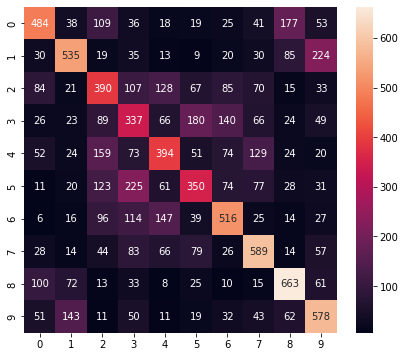

In [137]:
conf = confusion_matrix(Y_test_dense, preds)
plt.figure(figsize=(7,6))
sns.heatmap(conf, annot=True, fmt=',d');

In [135]:
print(conf.dtype)
conf

dtype('int64')

In [141]:
## Comment: There are no floats in the confusion matrix (since a fraction of a sample 
## can't be categorized corretly or incorrectly - only a whole picture), though I could 
## remove the scientific notations. 